In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import CategoricalDtype
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn import model_selection, ensemble, metrics, linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
import os
base_dir = '../data'
print(os.listdir(base_dir))


# Any results you write to the current directory are saved as output.https://www.kaggle.com/wanermiranda/linear-regression-ml-tp1?scriptVersionId=5240484

['test.pkl', 'diamonds.csv', 'train.pkl']


/root/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df_diamonds = pd.read_csv('%s/diamonds.csv'%(base_dir), index_col='Unnamed: 0')
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


## Numeric Features 
* Carat: weight of the diamond
* depth: depth %  The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
* table: table % The width of the diamond's table expressed as a percentage of its average diameter
* price: the price of the diamond
* xlength: mm
* ywidth: mm
* zdepth: mm

In [3]:
df_diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## cut 
Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal

In [4]:
cuts_ordered = ['Fair',
                'Good',
                'Very Good',
                'Premium',
                'Ideal']
df_diamonds['cut'] = df_diamonds['cut'].astype(CategoricalDtype(cuts_ordered, ordered=True))
print(df_diamonds['cut'].unique())
df_diamonds['cut'].describe()

[Ideal, Premium, Good, Very Good, Fair]
Categories (5, object): [Fair < Good < Very Good < Premium < Ideal]


count     53940
unique        5
top       Ideal
freq      21551
Name: cut, dtype: object

## color
mColor of the diamond, with D being the best and J the worst

In [5]:
colors_ordered = [  'J',
                    'I',
                    'H',
                    'G',
                    'F',
                    'E',
                    'D']
df_diamonds['color'] = df_diamonds['color'].astype(CategoricalDtype(colors_ordered, ordered=True))
print(df_diamonds['color'].unique())
df_diamonds['color'].describe()

[E, I, J, H, F, G, D]
Categories (7, object): [J < I < H < G < F < E < D]


count     53940
unique        7
top           G
freq      11292
Name: color, dtype: object

## clarity
How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3

In [6]:
clarity_codes = {'I3',
'I2',
'I1',
'SI2',
'SI1',
'VS2',
'VS1',
'VVS2',
'VVS1',
'IF',
'FL'}
df_diamonds['clarity'] = df_diamonds['clarity'].astype(CategoricalDtype(clarity_codes, ordered=True))
print(df_diamonds['clarity'].unique())
df_diamonds['clarity'].describe()

[SI2, SI1, VS1, VS2, VVS2, VVS1, I1, IF]
Categories (8, object): [SI1 < VS2 < VS1 < SI2 < I1 < VVS2 < IF < VVS1]


count     53940
unique        8
top         SI1
freq      13065
Name: clarity, dtype: object

## Cleaning the Data
There are some zero dimensions for the diamonds, since that must be noise or mistype, we are cleaning it.


In [7]:
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.x <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.y <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.z <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.carat <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.depth <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.table <= 0].index)

## Handcraft features
Since the measures for the diamond follow a 3d shape, we are considering here some handcraft features. 
Volume for the diamond = reflecting its size and weight. 
Ratio between the X, Y and Z.


In [8]:
df_diamonds['volume'] = df_diamonds['x'] * df_diamonds['y'] * df_diamonds['z']
df_diamonds['ratio_xy'] = df_diamonds['x'] / df_diamonds['y']
# df_diamonds['ratio_xz'] = df_diamonds['x'] / df_diamonds['z']
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio_xy
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030,0.992462
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856,1.013021
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885,0.995086
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580,0.992908
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250,0.997701
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48,38.693952,0.994949
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47,38.830870,0.992462
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53,42.321081,0.990268
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49,36.425214,1.023810
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39,38.718000,0.987654


In [9]:
train, test_reserved = model_selection.train_test_split(df_diamonds, test_size=0.2, random_state=42)
test_reserved.to_csv('test.csv')
train.to_csv('train.csv')

df_diamonds = train

# Distribution Overview
The prices seems to follow a power law curve, as show bellow in the graph. 

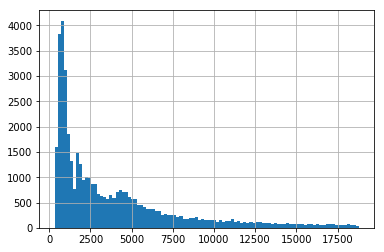

In [10]:
df_diamonds['price'].hist(bins=100)

In [11]:
df_diamonds['price'].describe()

count    43136.000000
mean      3926.531459
std       3983.079043
min        326.000000
25%        950.750000
50%       2398.000000
75%       5330.000000
max      18806.000000
Name: price, dtype: float64

## SGD Regression For Fun


In [12]:
cat_columns = df_diamonds.select_dtypes(['category']).columns.values
df_diamonds[cat_columns] = df_diamonds[cat_columns].apply(lambda x: x.cat.codes)



## Normalizing the Data
Using the robust scaller **to not only use the mean normalization**, but also to be less vulnerable to outliers.

In [13]:
X  = df_diamonds.copy()
y = X.pop('price')


## Regression
Since there is no negative values in the prices we are using here the log(price) to maintain this domain during the regression train. 
We are also using a 5 cross fold validation to do the grid search. 

A validation set was extracted from the data as a simulation for the test set.


In [14]:
from sklearn.model_selection import *

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.1, random_state=42)
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [15]:

    
def sklLinearRegressionModel(X_train,y_train,best_hyperparams):
	regression = linear_model.SGDRegressor(**best_hyperparams, penalty=None, verbose=True) 
	regression.fit(X_train, np.log(y_train))
	return regression


def crossValidationKFold(X_train,y_train):
	hyperparams = {
    	'learning_rate':['invscaling', 'optimal'],
    	'eta0': [0.1, 0.05, 0.01], 
    	'max_iter':[20000, 10000]
	}

	scoring = {
    	'NEG_MSE': 'neg_mean_squared_error',
    	'NEG_MAE': 'neg_mean_absolute_error',
    	'VARIANCE': 'r2'
	}

	regr = GridSearchCV(linear_model.SGDRegressor(), hyperparams, cv=5, scoring=scoring, refit='VARIANCE', n_jobs=-1, verbose=True)

	regr.fit(X_train, np.log(y_train))

	return regr.best_params_


best_hyperparams = {'learning_rate': 'invscaling', 'max_iter': 2000, 'eta0': 0.01}
regr = sklLinearRegressionModel(X_train,y_train,best_hyperparams)

-- Epoch 1
Norm: 2.41, NNZs: 11, Bias: 7.638633, T: 38822, Avg. loss: 0.258239
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.22, NNZs: 11, Bias: 7.722367, T: 77644, Avg. loss: 0.295718
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.45, NNZs: 11, Bias: 7.671545, T: 116466, Avg. loss: 0.049941
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.47, NNZs: 11, Bias: 7.752345, T: 155288, Avg. loss: 0.035176
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.54, NNZs: 11, Bias: 7.802519, T: 194110, Avg. loss: 0.024884
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 1.59, NNZs: 11, Bias: 7.796042, T: 232932, Avg. loss: 0.023970
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 1.62, NNZs: 11, Bias: 7.812476, T: 271754, Avg. loss: 0.023425
Total training time: 0.07 seconds.
-- Epoch 8
Norm: 1.63, NNZs: 11, Bias: 7.805523, T: 310576, Avg. loss: 0.023371
Total training time: 0.07 seconds.
-- Epoch 9
Norm: 1.64, NNZs: 11, Bias: 7.805850, T: 349398, Avg. loss: 0.023360
To

Norm: 1.73, NNZs: 11, Bias: 7.812937, T: 3649268, Avg. loss: 0.023188
Total training time: 0.83 seconds.
-- Epoch 95
Norm: 1.73, NNZs: 11, Bias: 7.811557, T: 3688090, Avg. loss: 0.023189
Total training time: 0.84 seconds.
-- Epoch 96
Norm: 1.73, NNZs: 11, Bias: 7.810509, T: 3726912, Avg. loss: 0.023191
Total training time: 0.85 seconds.
-- Epoch 97
Norm: 1.74, NNZs: 11, Bias: 7.814008, T: 3765734, Avg. loss: 0.023189
Total training time: 0.86 seconds.
-- Epoch 98
Norm: 1.73, NNZs: 11, Bias: 7.808355, T: 3804556, Avg. loss: 0.023174
Total training time: 0.87 seconds.
-- Epoch 99
Norm: 1.73, NNZs: 11, Bias: 7.808923, T: 3843378, Avg. loss: 0.023187
Total training time: 0.88 seconds.
-- Epoch 100
Norm: 1.74, NNZs: 11, Bias: 7.807735, T: 3882200, Avg. loss: 0.023188
Total training time: 0.89 seconds.
-- Epoch 101
Norm: 1.74, NNZs: 11, Bias: 7.811757, T: 3921022, Avg. loss: 0.023182
Total training time: 0.89 seconds.
-- Epoch 102
Norm: 1.74, NNZs: 11, Bias: 7.814412, T: 3959844, Avg. loss: 

Norm: 1.80, NNZs: 11, Bias: 7.810937, T: 7104426, Avg. loss: 0.023130
Total training time: 1.65 seconds.
-- Epoch 184
Norm: 1.80, NNZs: 11, Bias: 7.809385, T: 7143248, Avg. loss: 0.023105
Total training time: 1.66 seconds.
-- Epoch 185
Norm: 1.80, NNZs: 11, Bias: 7.808065, T: 7182070, Avg. loss: 0.023126
Total training time: 1.67 seconds.
-- Epoch 186
Norm: 1.80, NNZs: 11, Bias: 7.807180, T: 7220892, Avg. loss: 0.023127
Total training time: 1.68 seconds.
-- Epoch 187
Norm: 1.80, NNZs: 11, Bias: 7.807842, T: 7259714, Avg. loss: 0.023128
Total training time: 1.69 seconds.
-- Epoch 188
Norm: 1.80, NNZs: 11, Bias: 7.810278, T: 7298536, Avg. loss: 0.023128
Total training time: 1.70 seconds.
-- Epoch 189
Norm: 1.80, NNZs: 11, Bias: 7.809850, T: 7337358, Avg. loss: 0.023128
Total training time: 1.71 seconds.
-- Epoch 190
Norm: 1.80, NNZs: 11, Bias: 7.809945, T: 7376180, Avg. loss: 0.023129
Total training time: 1.72 seconds.
-- Epoch 191
Norm: 1.80, NNZs: 11, Bias: 7.809199, T: 7415002, Avg. l

Norm: 1.85, NNZs: 11, Bias: 7.808829, T: 10093720, Avg. loss: 0.023097
Total training time: 2.27 seconds.
-- Epoch 261
Norm: 1.85, NNZs: 11, Bias: 7.806640, T: 10132542, Avg. loss: 0.023091
Total training time: 2.28 seconds.
-- Epoch 262
Norm: 1.85, NNZs: 11, Bias: 7.811795, T: 10171364, Avg. loss: 0.023091
Total training time: 2.29 seconds.
-- Epoch 263
Norm: 1.85, NNZs: 11, Bias: 7.808139, T: 10210186, Avg. loss: 0.023082
Total training time: 2.30 seconds.
-- Epoch 264
Norm: 1.85, NNZs: 11, Bias: 7.808826, T: 10249008, Avg. loss: 0.023095
Total training time: 2.31 seconds.
-- Epoch 265
Norm: 1.86, NNZs: 11, Bias: 7.810499, T: 10287830, Avg. loss: 0.023094
Total training time: 2.32 seconds.
-- Epoch 266
Norm: 1.86, NNZs: 11, Bias: 7.809650, T: 10326652, Avg. loss: 0.023091
Total training time: 2.33 seconds.
-- Epoch 267
Norm: 1.86, NNZs: 11, Bias: 7.810529, T: 10365474, Avg. loss: 0.023094
Total training time: 2.33 seconds.
-- Epoch 268
Norm: 1.86, NNZs: 11, Bias: 7.806912, T: 1040429

Norm: 1.90, NNZs: 11, Bias: 7.808471, T: 13005370, Avg. loss: 0.023072
Total training time: 2.89 seconds.
-- Epoch 336
Norm: 1.90, NNZs: 11, Bias: 7.807556, T: 13044192, Avg. loss: 0.023069
Total training time: 2.90 seconds.
-- Epoch 337
Norm: 1.90, NNZs: 11, Bias: 7.808817, T: 13083014, Avg. loss: 0.023066
Total training time: 2.91 seconds.
-- Epoch 338
Norm: 1.90, NNZs: 11, Bias: 7.806942, T: 13121836, Avg. loss: 0.023066
Total training time: 2.92 seconds.
-- Epoch 339
Norm: 1.90, NNZs: 11, Bias: 7.805308, T: 13160658, Avg. loss: 0.023054
Total training time: 2.93 seconds.
-- Epoch 340
Norm: 1.90, NNZs: 11, Bias: 7.807647, T: 13199480, Avg. loss: 0.023069
Total training time: 2.93 seconds.
-- Epoch 341
Norm: 1.90, NNZs: 11, Bias: 7.809291, T: 13238302, Avg. loss: 0.023071
Total training time: 2.94 seconds.
-- Epoch 342
Norm: 1.90, NNZs: 11, Bias: 7.808738, T: 13277124, Avg. loss: 0.023067
Total training time: 2.95 seconds.
-- Epoch 343
Norm: 1.90, NNZs: 11, Bias: 7.809815, T: 1331594

Norm: 1.94, NNZs: 11, Bias: 7.809062, T: 15800554, Avg. loss: 0.023054
Total training time: 3.51 seconds.
-- Epoch 408
Norm: 1.94, NNZs: 11, Bias: 7.809639, T: 15839376, Avg. loss: 0.023056
Total training time: 3.52 seconds.
-- Epoch 409
Norm: 1.94, NNZs: 11, Bias: 7.809559, T: 15878198, Avg. loss: 0.023053
Total training time: 3.53 seconds.
-- Epoch 410
Norm: 1.94, NNZs: 11, Bias: 7.809365, T: 15917020, Avg. loss: 0.023054
Total training time: 3.54 seconds.
-- Epoch 411
Norm: 1.94, NNZs: 11, Bias: 7.809986, T: 15955842, Avg. loss: 0.023039
Total training time: 3.55 seconds.
-- Epoch 412
Norm: 1.94, NNZs: 11, Bias: 7.807502, T: 15994664, Avg. loss: 0.023056
Total training time: 3.56 seconds.
-- Epoch 413
Norm: 1.95, NNZs: 11, Bias: 7.806483, T: 16033486, Avg. loss: 0.023048
Total training time: 3.57 seconds.
-- Epoch 414
Norm: 1.95, NNZs: 11, Bias: 7.805968, T: 16072308, Avg. loss: 0.023055
Total training time: 3.58 seconds.
-- Epoch 415
Norm: 1.95, NNZs: 11, Bias: 7.806993, T: 1611113

Norm: 1.98, NNZs: 11, Bias: 7.807864, T: 18634560, Avg. loss: 0.023031
Total training time: 4.13 seconds.
-- Epoch 481
Norm: 1.98, NNZs: 11, Bias: 7.806632, T: 18673382, Avg. loss: 0.023037
Total training time: 4.14 seconds.
-- Epoch 482
Norm: 1.98, NNZs: 11, Bias: 7.809939, T: 18712204, Avg. loss: 0.023038
Total training time: 4.15 seconds.
-- Epoch 483
Norm: 1.98, NNZs: 11, Bias: 7.808778, T: 18751026, Avg. loss: 0.023041
Total training time: 4.16 seconds.
-- Epoch 484
Norm: 1.98, NNZs: 11, Bias: 7.807330, T: 18789848, Avg. loss: 0.023035
Total training time: 4.17 seconds.
-- Epoch 485
Norm: 1.98, NNZs: 11, Bias: 7.807811, T: 18828670, Avg. loss: 0.023031
Total training time: 4.18 seconds.
-- Epoch 486
Norm: 1.98, NNZs: 11, Bias: 7.809017, T: 18867492, Avg. loss: 0.023030
Total training time: 4.19 seconds.
-- Epoch 487
Norm: 1.98, NNZs: 11, Bias: 7.806546, T: 18906314, Avg. loss: 0.023028
Total training time: 4.20 seconds.
-- Epoch 488
Norm: 1.98, NNZs: 11, Bias: 7.808708, T: 1894513

Norm: 2.02, NNZs: 11, Bias: 7.805621, T: 21740320, Avg. loss: 0.023021
Total training time: 4.96 seconds.
-- Epoch 561
Norm: 2.02, NNZs: 11, Bias: 7.805485, T: 21779142, Avg. loss: 0.023024
Total training time: 4.97 seconds.
-- Epoch 562
Norm: 2.02, NNZs: 11, Bias: 7.805241, T: 21817964, Avg. loss: 0.023020
Total training time: 4.98 seconds.
-- Epoch 563
Norm: 2.02, NNZs: 11, Bias: 7.806633, T: 21856786, Avg. loss: 0.023028
Total training time: 4.99 seconds.
-- Epoch 564
Norm: 2.02, NNZs: 11, Bias: 7.809871, T: 21895608, Avg. loss: 0.023021
Total training time: 5.00 seconds.
-- Epoch 565
Norm: 2.02, NNZs: 11, Bias: 7.807403, T: 21934430, Avg. loss: 0.023025
Total training time: 5.01 seconds.
-- Epoch 566
Norm: 2.02, NNZs: 11, Bias: 7.807963, T: 21973252, Avg. loss: 0.023022
Total training time: 5.02 seconds.
-- Epoch 567
Norm: 2.02, NNZs: 11, Bias: 7.807663, T: 22012074, Avg. loss: 0.023021
Total training time: 5.03 seconds.
-- Epoch 568
Norm: 2.02, NNZs: 11, Bias: 7.804739, T: 2205089

Norm: 2.06, NNZs: 11, Bias: 7.806895, T: 24807258, Avg. loss: 0.023011
Total training time: 5.78 seconds.
-- Epoch 640
Norm: 2.06, NNZs: 11, Bias: 7.808796, T: 24846080, Avg. loss: 0.023003
Total training time: 5.79 seconds.
-- Epoch 641
Norm: 2.06, NNZs: 11, Bias: 7.807047, T: 24884902, Avg. loss: 0.023012
Total training time: 5.80 seconds.
-- Epoch 642
Norm: 2.06, NNZs: 11, Bias: 7.806268, T: 24923724, Avg. loss: 0.023004
Total training time: 5.81 seconds.
-- Epoch 643
Norm: 2.06, NNZs: 11, Bias: 7.807431, T: 24962546, Avg. loss: 0.023017
Total training time: 5.82 seconds.
-- Epoch 644
Norm: 2.06, NNZs: 11, Bias: 7.805067, T: 25001368, Avg. loss: 0.023015
Total training time: 5.83 seconds.
-- Epoch 645
Norm: 2.06, NNZs: 11, Bias: 7.808350, T: 25040190, Avg. loss: 0.023012
Total training time: 5.84 seconds.
-- Epoch 646
Norm: 2.06, NNZs: 11, Bias: 7.808004, T: 25079012, Avg. loss: 0.023014
Total training time: 5.85 seconds.
-- Epoch 647
Norm: 2.06, NNZs: 11, Bias: 7.806061, T: 2511783

Norm: 2.09, NNZs: 11, Bias: 7.804387, T: 27951840, Avg. loss: 0.022997
Total training time: 6.60 seconds.
-- Epoch 721
Norm: 2.09, NNZs: 11, Bias: 7.807910, T: 27990662, Avg. loss: 0.022999
Total training time: 6.61 seconds.
-- Epoch 722
Norm: 2.09, NNZs: 11, Bias: 7.809341, T: 28029484, Avg. loss: 0.023004
Total training time: 6.62 seconds.
-- Epoch 723
Norm: 2.09, NNZs: 11, Bias: 7.807766, T: 28068306, Avg. loss: 0.023000
Total training time: 6.63 seconds.
-- Epoch 724
Norm: 2.09, NNZs: 11, Bias: 7.806944, T: 28107128, Avg. loss: 0.023003
Total training time: 6.64 seconds.
-- Epoch 725
Norm: 2.09, NNZs: 11, Bias: 7.805871, T: 28145950, Avg. loss: 0.023001
Total training time: 6.65 seconds.
-- Epoch 726
Norm: 2.09, NNZs: 11, Bias: 7.807313, T: 28184772, Avg. loss: 0.023002
Total training time: 6.65 seconds.
-- Epoch 727
Norm: 2.09, NNZs: 11, Bias: 7.805589, T: 28223594, Avg. loss: 0.023003
Total training time: 6.66 seconds.
-- Epoch 728
Norm: 2.09, NNZs: 11, Bias: 7.807076, T: 2826241

Norm: 2.13, NNZs: 11, Bias: 7.807199, T: 31406998, Avg. loss: 0.022996
Total training time: 7.43 seconds.
-- Epoch 810
Norm: 2.13, NNZs: 11, Bias: 7.806710, T: 31445820, Avg. loss: 0.022995
Total training time: 7.44 seconds.
-- Epoch 811
Norm: 2.13, NNZs: 11, Bias: 7.809868, T: 31484642, Avg. loss: 0.022992
Total training time: 7.45 seconds.
-- Epoch 812
Norm: 2.13, NNZs: 11, Bias: 7.806119, T: 31523464, Avg. loss: 0.022998
Total training time: 7.46 seconds.
-- Epoch 813
Norm: 2.13, NNZs: 11, Bias: 7.806701, T: 31562286, Avg. loss: 0.022997
Total training time: 7.47 seconds.
-- Epoch 814
Norm: 2.13, NNZs: 11, Bias: 7.804508, T: 31601108, Avg. loss: 0.022995
Total training time: 7.48 seconds.
-- Epoch 815
Norm: 2.13, NNZs: 11, Bias: 7.806659, T: 31639930, Avg. loss: 0.022992
Total training time: 7.49 seconds.
-- Epoch 816
Norm: 2.13, NNZs: 11, Bias: 7.805334, T: 31678752, Avg. loss: 0.022991
Total training time: 7.50 seconds.
-- Epoch 817
Norm: 2.13, NNZs: 11, Bias: 7.807938, T: 3171757

Norm: 2.15, NNZs: 11, Bias: 7.804870, T: 34279826, Avg. loss: 0.022990
Total training time: 8.04 seconds.
-- Epoch 884
Norm: 2.15, NNZs: 11, Bias: 7.805263, T: 34318648, Avg. loss: 0.022985
Total training time: 8.05 seconds.
-- Epoch 885
Norm: 2.15, NNZs: 11, Bias: 7.804874, T: 34357470, Avg. loss: 0.022990
Total training time: 8.06 seconds.
-- Epoch 886
Norm: 2.15, NNZs: 11, Bias: 7.806212, T: 34396292, Avg. loss: 0.022989
Total training time: 8.07 seconds.
-- Epoch 887
Norm: 2.15, NNZs: 11, Bias: 7.805364, T: 34435114, Avg. loss: 0.022991
Total training time: 8.07 seconds.
-- Epoch 888
Norm: 2.15, NNZs: 11, Bias: 7.804980, T: 34473936, Avg. loss: 0.022988
Total training time: 8.08 seconds.
-- Epoch 889
Norm: 2.16, NNZs: 11, Bias: 7.806410, T: 34512758, Avg. loss: 0.022990
Total training time: 8.09 seconds.
-- Epoch 890
Norm: 2.16, NNZs: 11, Bias: 7.806016, T: 34551580, Avg. loss: 0.022992
Total training time: 8.09 seconds.
-- Epoch 891
Norm: 2.16, NNZs: 11, Bias: 7.805455, T: 3459040

Norm: 2.18, NNZs: 11, Bias: 7.806118, T: 37307942, Avg. loss: 0.022979
Total training time: 8.66 seconds.
-- Epoch 962
Norm: 2.18, NNZs: 11, Bias: 7.804987, T: 37346764, Avg. loss: 0.022983
Total training time: 8.67 seconds.
-- Epoch 963
Norm: 2.18, NNZs: 11, Bias: 7.805399, T: 37385586, Avg. loss: 0.022985
Total training time: 8.68 seconds.
-- Epoch 964
Norm: 2.18, NNZs: 11, Bias: 7.806124, T: 37424408, Avg. loss: 0.022981
Total training time: 8.69 seconds.
-- Epoch 965
Norm: 2.18, NNZs: 11, Bias: 7.804903, T: 37463230, Avg. loss: 0.022985
Total training time: 8.70 seconds.
-- Epoch 966
Norm: 2.18, NNZs: 11, Bias: 7.806375, T: 37502052, Avg. loss: 0.022984
Total training time: 8.71 seconds.
-- Epoch 967
Norm: 2.18, NNZs: 11, Bias: 7.805568, T: 37540874, Avg. loss: 0.022981
Total training time: 8.71 seconds.
-- Epoch 968
Norm: 2.18, NNZs: 11, Bias: 7.804581, T: 37579696, Avg. loss: 0.022985
Total training time: 8.72 seconds.
-- Epoch 969
Norm: 2.18, NNZs: 11, Bias: 7.804933, T: 3761851

Norm: 2.21, NNZs: 11, Bias: 7.806658, T: 40336058, Avg. loss: 0.022975
Total training time: 9.28 seconds.
-- Epoch 1040
Norm: 2.21, NNZs: 11, Bias: 7.806213, T: 40374880, Avg. loss: 0.022980
Total training time: 9.29 seconds.
-- Epoch 1041
Norm: 2.21, NNZs: 11, Bias: 7.803949, T: 40413702, Avg. loss: 0.022977
Total training time: 9.29 seconds.
-- Epoch 1042
Norm: 2.21, NNZs: 11, Bias: 7.805935, T: 40452524, Avg. loss: 0.022974
Total training time: 9.30 seconds.
-- Epoch 1043
Norm: 2.21, NNZs: 11, Bias: 7.805558, T: 40491346, Avg. loss: 0.022982
Total training time: 9.31 seconds.
-- Epoch 1044
Norm: 2.21, NNZs: 11, Bias: 7.805216, T: 40530168, Avg. loss: 0.022975
Total training time: 9.32 seconds.
-- Epoch 1045
Norm: 2.21, NNZs: 11, Bias: 7.805007, T: 40568990, Avg. loss: 0.022980
Total training time: 9.33 seconds.
-- Epoch 1046
Norm: 2.21, NNZs: 11, Bias: 7.806081, T: 40607812, Avg. loss: 0.022975
Total training time: 9.34 seconds.
-- Epoch 1047
Norm: 2.21, NNZs: 11, Bias: 7.805756, T:

Norm: 2.23, NNZs: 11, Bias: 7.806129, T: 43208886, Avg. loss: 0.022974
Total training time: 9.89 seconds.
-- Epoch 1114
Norm: 2.23, NNZs: 11, Bias: 7.804634, T: 43247708, Avg. loss: 0.022968
Total training time: 9.90 seconds.
-- Epoch 1115
Norm: 2.23, NNZs: 11, Bias: 7.805554, T: 43286530, Avg. loss: 0.022972
Total training time: 9.91 seconds.
-- Epoch 1116
Norm: 2.23, NNZs: 11, Bias: 7.804787, T: 43325352, Avg. loss: 0.022975
Total training time: 9.91 seconds.
-- Epoch 1117
Norm: 2.23, NNZs: 11, Bias: 7.805193, T: 43364174, Avg. loss: 0.022971
Total training time: 9.92 seconds.
-- Epoch 1118
Norm: 2.23, NNZs: 11, Bias: 7.805151, T: 43402996, Avg. loss: 0.022975
Total training time: 9.93 seconds.
-- Epoch 1119
Norm: 2.23, NNZs: 11, Bias: 7.805454, T: 43441818, Avg. loss: 0.022975
Total training time: 9.94 seconds.
-- Epoch 1120
Norm: 2.23, NNZs: 11, Bias: 7.805909, T: 43480640, Avg. loss: 0.022973
Total training time: 9.95 seconds.
-- Epoch 1121
Norm: 2.23, NNZs: 11, Bias: 7.805850, T:

Norm: 2.25, NNZs: 11, Bias: 7.803654, T: 46159358, Avg. loss: 0.022970
Total training time: 10.51 seconds.
-- Epoch 1190
Norm: 2.25, NNZs: 11, Bias: 7.805646, T: 46198180, Avg. loss: 0.022972
Total training time: 10.52 seconds.
-- Epoch 1191
Norm: 2.25, NNZs: 11, Bias: 7.805224, T: 46237002, Avg. loss: 0.022966
Total training time: 10.53 seconds.
-- Epoch 1192
Norm: 2.25, NNZs: 11, Bias: 7.804611, T: 46275824, Avg. loss: 0.022968
Total training time: 10.54 seconds.
-- Epoch 1193
Norm: 2.25, NNZs: 11, Bias: 7.806811, T: 46314646, Avg. loss: 0.022966
Total training time: 10.54 seconds.
-- Epoch 1194
Norm: 2.25, NNZs: 11, Bias: 7.803917, T: 46353468, Avg. loss: 0.022965
Total training time: 10.55 seconds.
-- Epoch 1195
Norm: 2.25, NNZs: 11, Bias: 7.804139, T: 46392290, Avg. loss: 0.022972
Total training time: 10.56 seconds.
-- Epoch 1196
Norm: 2.25, NNZs: 11, Bias: 7.805839, T: 46431112, Avg. loss: 0.022967
Total training time: 10.57 seconds.
-- Epoch 1197
Norm: 2.25, NNZs: 11, Bias: 7.80

Norm: 2.27, NNZs: 11, Bias: 7.803641, T: 49226296, Avg. loss: 0.022965
Total training time: 11.14 seconds.
-- Epoch 1269
Norm: 2.27, NNZs: 11, Bias: 7.804668, T: 49265118, Avg. loss: 0.022966
Total training time: 11.15 seconds.
-- Epoch 1270
Norm: 2.27, NNZs: 11, Bias: 7.805897, T: 49303940, Avg. loss: 0.022965
Total training time: 11.15 seconds.
-- Epoch 1271
Norm: 2.27, NNZs: 11, Bias: 7.802968, T: 49342762, Avg. loss: 0.022964
Total training time: 11.16 seconds.
-- Epoch 1272
Norm: 2.28, NNZs: 11, Bias: 7.805641, T: 49381584, Avg. loss: 0.022965
Total training time: 11.17 seconds.
-- Epoch 1273
Norm: 2.28, NNZs: 11, Bias: 7.804578, T: 49420406, Avg. loss: 0.022964
Total training time: 11.18 seconds.
-- Epoch 1274
Norm: 2.27, NNZs: 11, Bias: 7.805523, T: 49459228, Avg. loss: 0.022969
Total training time: 11.19 seconds.
-- Epoch 1275
Norm: 2.27, NNZs: 11, Bias: 7.805160, T: 49498050, Avg. loss: 0.022969
Total training time: 11.20 seconds.
-- Epoch 1276
Norm: 2.28, NNZs: 11, Bias: 7.80

Norm: 2.30, NNZs: 11, Bias: 7.806115, T: 52603810, Avg. loss: 0.022960
Total training time: 11.96 seconds.
-- Epoch 1356
Norm: 2.30, NNZs: 11, Bias: 7.803345, T: 52642632, Avg. loss: 0.022963
Total training time: 11.97 seconds.
-- Epoch 1357
Norm: 2.30, NNZs: 11, Bias: 7.806108, T: 52681454, Avg. loss: 0.022960
Total training time: 11.98 seconds.
-- Epoch 1358
Norm: 2.30, NNZs: 11, Bias: 7.806179, T: 52720276, Avg. loss: 0.022961
Total training time: 11.99 seconds.
-- Epoch 1359
Norm: 2.30, NNZs: 11, Bias: 7.804930, T: 52759098, Avg. loss: 0.022965
Total training time: 12.00 seconds.
-- Epoch 1360
Norm: 2.30, NNZs: 11, Bias: 7.804716, T: 52797920, Avg. loss: 0.022962
Total training time: 12.01 seconds.
-- Epoch 1361
Norm: 2.30, NNZs: 11, Bias: 7.804897, T: 52836742, Avg. loss: 0.022964
Total training time: 12.01 seconds.
-- Epoch 1362
Norm: 2.30, NNZs: 11, Bias: 7.804814, T: 52875564, Avg. loss: 0.022964
Total training time: 12.02 seconds.
-- Epoch 1363
Norm: 2.30, NNZs: 11, Bias: 7.80

Norm: 2.31, NNZs: 11, Bias: 7.805126, T: 55437816, Avg. loss: 0.022961
Total training time: 12.58 seconds.
-- Epoch 1429
Norm: 2.31, NNZs: 11, Bias: 7.805962, T: 55476638, Avg. loss: 0.022961
Total training time: 12.59 seconds.
-- Epoch 1430
Norm: 2.31, NNZs: 11, Bias: 7.806355, T: 55515460, Avg. loss: 0.022957
Total training time: 12.60 seconds.
-- Epoch 1431
Norm: 2.31, NNZs: 11, Bias: 7.807189, T: 55554282, Avg. loss: 0.022960
Total training time: 12.61 seconds.
-- Epoch 1432
Norm: 2.31, NNZs: 11, Bias: 7.805656, T: 55593104, Avg. loss: 0.022961
Total training time: 12.62 seconds.
-- Epoch 1433
Norm: 2.31, NNZs: 11, Bias: 7.804587, T: 55631926, Avg. loss: 0.022953
Total training time: 12.63 seconds.
-- Epoch 1434
Norm: 2.32, NNZs: 11, Bias: 7.804557, T: 55670748, Avg. loss: 0.022959
Total training time: 12.64 seconds.
-- Epoch 1435
Norm: 2.31, NNZs: 11, Bias: 7.805054, T: 55709570, Avg. loss: 0.022963
Total training time: 12.65 seconds.
-- Epoch 1436
Norm: 2.31, NNZs: 11, Bias: 7.80

Norm: 2.33, NNZs: 11, Bias: 7.805934, T: 58660042, Avg. loss: 0.022956
Total training time: 13.41 seconds.
-- Epoch 1512
Norm: 2.33, NNZs: 11, Bias: 7.804846, T: 58698864, Avg. loss: 0.022957
Total training time: 13.42 seconds.
-- Epoch 1513
Norm: 2.33, NNZs: 11, Bias: 7.804776, T: 58737686, Avg. loss: 0.022956
Total training time: 13.43 seconds.
-- Epoch 1514
Norm: 2.33, NNZs: 11, Bias: 7.804465, T: 58776508, Avg. loss: 0.022960
Total training time: 13.44 seconds.
-- Epoch 1515
Norm: 2.33, NNZs: 11, Bias: 7.805666, T: 58815330, Avg. loss: 0.022957
Total training time: 13.45 seconds.
-- Epoch 1516
Norm: 2.33, NNZs: 11, Bias: 7.805480, T: 58854152, Avg. loss: 0.022958
Total training time: 13.46 seconds.
-- Epoch 1517
Norm: 2.33, NNZs: 11, Bias: 7.804541, T: 58892974, Avg. loss: 0.022960
Total training time: 13.47 seconds.
-- Epoch 1518
Norm: 2.33, NNZs: 11, Bias: 7.804267, T: 58931796, Avg. loss: 0.022957
Total training time: 13.48 seconds.
-- Epoch 1519
Norm: 2.33, NNZs: 11, Bias: 7.80

Norm: 2.35, NNZs: 11, Bias: 7.805130, T: 62037556, Avg. loss: 0.022955
Total training time: 14.23 seconds.
-- Epoch 1599
Norm: 2.35, NNZs: 11, Bias: 7.803922, T: 62076378, Avg. loss: 0.022950
Total training time: 14.24 seconds.
-- Epoch 1600
Norm: 2.35, NNZs: 11, Bias: 7.804948, T: 62115200, Avg. loss: 0.022955
Total training time: 14.25 seconds.
-- Epoch 1601
Norm: 2.35, NNZs: 11, Bias: 7.807166, T: 62154022, Avg. loss: 0.022953
Total training time: 14.26 seconds.
-- Epoch 1602
Norm: 2.35, NNZs: 11, Bias: 7.803064, T: 62192844, Avg. loss: 0.022951
Total training time: 14.27 seconds.
-- Epoch 1603
Norm: 2.35, NNZs: 11, Bias: 7.803332, T: 62231666, Avg. loss: 0.022955
Total training time: 14.27 seconds.
-- Epoch 1604
Norm: 2.35, NNZs: 11, Bias: 7.804658, T: 62270488, Avg. loss: 0.022952
Total training time: 14.28 seconds.
-- Epoch 1605
Norm: 2.35, NNZs: 11, Bias: 7.804811, T: 62309310, Avg. loss: 0.022954
Total training time: 14.29 seconds.
-- Epoch 1606
Norm: 2.35, NNZs: 11, Bias: 7.80

Norm: 2.37, NNZs: 11, Bias: 7.806381, T: 65415070, Avg. loss: 0.022951
Total training time: 15.06 seconds.
-- Epoch 1686
Norm: 2.37, NNZs: 11, Bias: 7.804361, T: 65453892, Avg. loss: 0.022954
Total training time: 15.07 seconds.
-- Epoch 1687
Norm: 2.37, NNZs: 11, Bias: 7.804786, T: 65492714, Avg. loss: 0.022949
Total training time: 15.08 seconds.
-- Epoch 1688
Norm: 2.37, NNZs: 11, Bias: 7.804857, T: 65531536, Avg. loss: 0.022955
Total training time: 15.09 seconds.
-- Epoch 1689
Norm: 2.37, NNZs: 11, Bias: 7.806137, T: 65570358, Avg. loss: 0.022953
Total training time: 15.10 seconds.
-- Epoch 1690
Norm: 2.37, NNZs: 11, Bias: 7.804424, T: 65609180, Avg. loss: 0.022952
Total training time: 15.11 seconds.
-- Epoch 1691
Norm: 2.37, NNZs: 11, Bias: 7.804055, T: 65648002, Avg. loss: 0.022955
Total training time: 15.12 seconds.
-- Epoch 1692
Norm: 2.37, NNZs: 11, Bias: 7.804125, T: 65686824, Avg. loss: 0.022956
Total training time: 15.13 seconds.
-- Epoch 1693
Norm: 2.37, NNZs: 11, Bias: 7.80

Norm: 2.38, NNZs: 11, Bias: 7.805507, T: 68054966, Avg. loss: 0.022950
Total training time: 15.68 seconds.
-- Epoch 1754
Norm: 2.38, NNZs: 11, Bias: 7.804429, T: 68093788, Avg. loss: 0.022949
Total training time: 15.69 seconds.
-- Epoch 1755
Norm: 2.38, NNZs: 11, Bias: 7.803890, T: 68132610, Avg. loss: 0.022954
Total training time: 15.70 seconds.
-- Epoch 1756
Norm: 2.38, NNZs: 11, Bias: 7.803186, T: 68171432, Avg. loss: 0.022950
Total training time: 15.71 seconds.
-- Epoch 1757
Norm: 2.38, NNZs: 11, Bias: 7.805016, T: 68210254, Avg. loss: 0.022950
Total training time: 15.72 seconds.
-- Epoch 1758
Norm: 2.38, NNZs: 11, Bias: 7.803932, T: 68249076, Avg. loss: 0.022952
Total training time: 15.73 seconds.
-- Epoch 1759
Norm: 2.38, NNZs: 11, Bias: 7.803739, T: 68287898, Avg. loss: 0.022946
Total training time: 15.74 seconds.
-- Epoch 1760
Norm: 2.38, NNZs: 11, Bias: 7.803212, T: 68326720, Avg. loss: 0.022951
Total training time: 15.75 seconds.
-- Epoch 1761
Norm: 2.38, NNZs: 11, Bias: 7.80

Norm: 2.40, NNZs: 11, Bias: 7.804763, T: 71005438, Avg. loss: 0.022950
Total training time: 16.30 seconds.
-- Epoch 1830
Norm: 2.40, NNZs: 11, Bias: 7.804210, T: 71044260, Avg. loss: 0.022948
Total training time: 16.31 seconds.
-- Epoch 1831
Norm: 2.40, NNZs: 11, Bias: 7.803949, T: 71083082, Avg. loss: 0.022955
Total training time: 16.32 seconds.
-- Epoch 1832
Norm: 2.40, NNZs: 11, Bias: 7.803178, T: 71121904, Avg. loss: 0.022948
Total training time: 16.32 seconds.
-- Epoch 1833
Norm: 2.40, NNZs: 11, Bias: 7.803329, T: 71160726, Avg. loss: 0.022949
Total training time: 16.33 seconds.
-- Epoch 1834
Norm: 2.40, NNZs: 11, Bias: 7.804831, T: 71199548, Avg. loss: 0.022947
Total training time: 16.34 seconds.
-- Epoch 1835
Norm: 2.40, NNZs: 11, Bias: 7.803826, T: 71238370, Avg. loss: 0.022952
Total training time: 16.35 seconds.
-- Epoch 1836
Norm: 2.40, NNZs: 11, Bias: 7.805700, T: 71277192, Avg. loss: 0.022949
Total training time: 16.35 seconds.
-- Epoch 1837
Norm: 2.40, NNZs: 11, Bias: 7.80

Norm: 2.41, NNZs: 11, Bias: 7.802986, T: 74072376, Avg. loss: 0.022945
Total training time: 16.92 seconds.
-- Epoch 1909
Norm: 2.41, NNZs: 11, Bias: 7.804620, T: 74111198, Avg. loss: 0.022947
Total training time: 16.93 seconds.
-- Epoch 1910
Norm: 2.41, NNZs: 11, Bias: 7.806134, T: 74150020, Avg. loss: 0.022948
Total training time: 16.94 seconds.
-- Epoch 1911
Norm: 2.41, NNZs: 11, Bias: 7.803186, T: 74188842, Avg. loss: 0.022938
Total training time: 16.94 seconds.
-- Epoch 1912
Norm: 2.41, NNZs: 11, Bias: 7.802586, T: 74227664, Avg. loss: 0.022949
Total training time: 16.95 seconds.
-- Epoch 1913
Norm: 2.41, NNZs: 11, Bias: 7.803925, T: 74266486, Avg. loss: 0.022950
Total training time: 16.96 seconds.
-- Epoch 1914
Norm: 2.41, NNZs: 11, Bias: 7.804869, T: 74305308, Avg. loss: 0.022950
Total training time: 16.97 seconds.
-- Epoch 1915
Norm: 2.41, NNZs: 11, Bias: 7.802407, T: 74344130, Avg. loss: 0.022947
Total training time: 16.97 seconds.
-- Epoch 1916
Norm: 2.41, NNZs: 11, Bias: 7.80

Norm: 2.42, NNZs: 11, Bias: 7.803122, T: 76984026, Avg. loss: 0.022948
Total training time: 17.55 seconds.
-- Epoch 1984
Norm: 2.42, NNZs: 11, Bias: 7.803286, T: 77022848, Avg. loss: 0.022945
Total training time: 17.56 seconds.
-- Epoch 1985
Norm: 2.42, NNZs: 11, Bias: 7.803639, T: 77061670, Avg. loss: 0.022947
Total training time: 17.57 seconds.
-- Epoch 1986
Norm: 2.42, NNZs: 11, Bias: 7.805489, T: 77100492, Avg. loss: 0.022949
Total training time: 17.57 seconds.
-- Epoch 1987
Norm: 2.42, NNZs: 11, Bias: 7.802948, T: 77139314, Avg. loss: 0.022941
Total training time: 17.58 seconds.
-- Epoch 1988
Norm: 2.42, NNZs: 11, Bias: 7.806055, T: 77178136, Avg. loss: 0.022944
Total training time: 17.59 seconds.
-- Epoch 1989
Norm: 2.42, NNZs: 11, Bias: 7.804729, T: 77216958, Avg. loss: 0.022948
Total training time: 17.60 seconds.
-- Epoch 1990
Norm: 2.42, NNZs: 11, Bias: 7.804059, T: 77255780, Avg. loss: 0.022944
Total training time: 17.60 seconds.
-- Epoch 1991
Norm: 2.42, NNZs: 11, Bias: 7.80

In [35]:
scoring = {
    	'NEG_MSE': 'neg_mean_squared_error',
    	'NEG_MAE': 'neg_mean_absolute_error',
    	'VARIANCE': 'r2'
	}

for k, score in scoring.items(): 
    regr.verbose = False
    scores = model_selection.cross_val_score(regr, X_train, y_train, cv=5, scoring=score, n_jobs=-1, verbose=True)
    print (k,  np.mean(scores), np.std(scores))
        

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.8s remaining:   20.7s


NEG_MSE -5910787.923477363 7762147.388241177


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.6s remaining:   20.5s


VARIANCE 0.6262124502000876 0.4915964787597655


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.9s remaining:   22.4s


NEG_MAE -867.6619220053663 17.8657698368305


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished


In [17]:
# regr.best_params_

In [18]:
y_val.describe()

count     4314.000000
mean      3875.490728
std       4008.860719
min        344.000000
25%        956.000000
50%       2316.000000
75%       5195.750000
max      18803.000000
Name: price, dtype: float64

In [19]:
y_pred = np.exp(regr.predict(X_val))
pd.Series(y_pred).describe()

count     4314.000000
mean      3765.956410
std       3756.560884
min        290.576939
25%        951.645007
50%       2355.491510
75%       5322.644072
max      25462.810339
dtype: float64

MSE: 1851283.028
MAE: 712.655
R2: 0.885


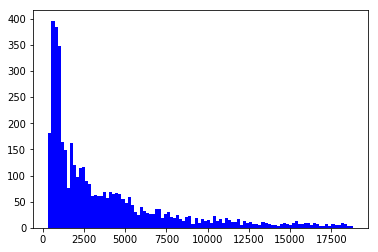

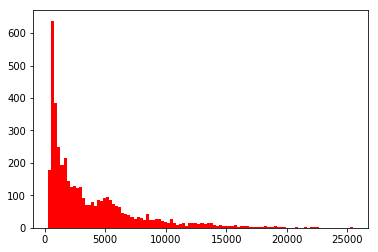

In [20]:
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()

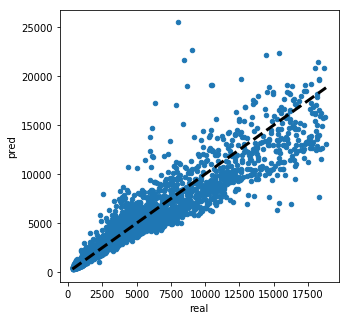

In [21]:
df = pd.DataFrame({'real': y_val, 'pred': y_pred})
ax = df.sort_values('real').plot.scatter('real', 'pred', figsize=(5, 5))
_ = ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)

In [22]:
def oneHotEncoding(features,columnName):
	currentCol = features.columns.get_loc(columnName)
	uniqueFeatures = features[columnName].unique()
	print(uniqueFeatures)
	for f in range(len(uniqueFeatures)):
		features.insert(loc=currentCol+f,column=columnName+str(f),value=0)
		features[columnName+str(f)][features[columnName]==uniqueFeatures[f]] = 1
		
	features.pop(columnName)

def dummieCoding(features,columnName,orderedFeature):
	c = 0
	for f in range(len(orderedFeature)):
		features[columnName][features[columnName]==orderedFeature[f]] = 2**c
		c = c + 1

In [23]:
def RMSE(theta,X,y):
	y_linha = hypothesis(theta,X)
	error = math.sqrt(((y_linha-y)**2).mean())
	return error

#
#  For linear regression, it is possible to estimate the values
# of all parameters theta by applying the normal equation method,
# which corresponds to the following equation:
#
#  Theta = (Xt.X)^-1.Xt.y
#
#  This procedure is called Normal Equation, which is implemented
# here
#
# params:
#   X -> set of features
#   Y -> set of targets
#
# return:
#   theta -> set of parameters
#
def normalEquation(X,y):
	X = np.insert(X,0,1,axis=1)
	npX = np.copy(X)
	npY = y.transpose()
	npXt = npX.transpose()

	R1 = np.matmul(npXt,npX)

	det = np.linalg.det(R1)

	if (det != 0):
		R1 = np.linalg.inv(R1)
		R2 = np.matmul(npXt,npY)
		theta = np.matmul(R1,R2)
	else:
		theta = []
		print("Error! Matrix (Xt.X) has no inverse.")

	error = RMSE(theta,X,y)
	print("Normal Equation --- RMSE error: ",str(error))

	X = np.delete(X,0,axis=1)

	return theta

In [24]:
theta = np.array([1, 0, 1], dtype=np.double)
theta_temp = np.array([0, 0, 0], dtype=np.double)
y = np.array([5.,10.], dtype=np.double)
X = np.array([[0.,1., 2.],[0.,2., 3.]], dtype=np.double)
print (X)
alpha = .01
max_iter = 50

[[0. 1. 2.]
 [0. 2. 3.]]


In [25]:
def hypothesis(theta, X):
    return np.sum(theta.T * X, axis=1)
    
def MSE_theta(theta, X, y, alpha,j, h0, error):                
        S = np.sum(np.matmul(error, X[:,j]))                
        result = theta[j] - (alpha * (1. / len(y)) * S)        
        return result

for i in range(max_iter):
    h0 = hypothesis(theta, X)
    error = (h0 - y)
    for j in range(X.shape[1]):
        theta_temp[j] = MSE_theta(theta, X, y, alpha, j, h0, error)    
        
    theta = theta_temp.copy()
    print (theta)    

hypothesis(theta, X)

[1.    0.085 1.135]
[1.       0.162475 1.257825]
[1.         0.23310013 1.36956737]
[1.         0.29748993 1.47122149]
[1.         0.35620382 1.5636925 ]
[1.         0.40975102 1.64780433]
[1.         0.45859507 1.72430701]
[1.         0.50315792 1.79388325]
[1.         0.54382364 1.85715452]
[1.         0.58094187 1.91468653]
[1.         0.61483086 1.96699423]
[1.         0.64578032 2.01454637]
[1.         0.67405396 2.05776965]
[1.         0.69989182 2.09705246]
[1.         0.72351243 2.13274838]
[1.         0.74511468 2.16517924]
[1.         0.76487964 2.194638  ]
[1.         0.78297213 2.22139134]
[1.         0.79954218 2.24568202]
[1.         0.81472634 2.267731  ]
[1.         0.82864894 2.28773943]
[1.         0.84142314 2.30589041]
[1.         0.85315195 2.32235061]
[1.         0.86392912 2.33727174]
[1.         0.87384003 2.35079191]
[1.         0.88296235 2.36303684]
[1.         0.89136682 2.37412095]
[1.         0.89911781 2.38414842]
[1.         0.90627393 2.39321406]
[1.   

array([5.91038925, 9.35683622])

In [26]:
import math

import math


def SGD_(alpha, max_iter, X, y):
    
    # Creating theta0 
    X = np.insert(X, values=1, obj=0, axis=1)
    
    shape = X.shape
    nsamples = shape[0]
    print("Number of samples: "+str(nsamples))
    theta0 = np.zeros(nsamples)
    nparams = shape[1]
    print("Number of parameters: "+str(nparams))


    theta = np.random.uniform(size=nparams)
    theta_temp = np.ones(nparams)

    error = 1
    epsilon = 0.001
    it = 0
    i = 0   
    power_t = 0.25
    t=1.0
    
    while ((error > epsilon) and (it < max_iter)):
        h0 = hypothesis(theta, X)
        eta = alpha / pow(t, power_t)
        error = (h0 - y)
        for j in range(nparams):
            theta_temp[j] = MSE_theta(theta, X, y, eta, j, h0, error)                
        it += 1
        i += 1
        y_pred = hypothesis(theta_temp, X)
#         print (y,hyphotesis(theta_temp, X))
        error =  ((y - y_pred) ** 2).mean() / 2 
#         print(theta)
#         print(theta_temp)

        theta = theta_temp.copy()
        
        if (i % 100) == 0 or i == 1:
            print("Epoch: %s Batch: %s Error: %.8f lr: %.8f "%(it, i, error, eta))
        t += 1            
   
    return theta
def predict(theta, X):
    X = np.insert(X, values=1, obj=0, axis=1)
    return hypothesis(theta_h, X)

max_iter = 10000
theta_h = SGD_(alpha, max_iter, X, y)
print (y,predict(theta_h, X))


Number of samples: 2
Number of parameters: 4
Epoch: 1 Batch: 1 Error: 7.64781994 lr: 0.01000000 
Epoch: 100 Batch: 100 Error: 0.31804806 lr: 0.00316228 
Epoch: 200 Batch: 200 Error: 0.30265521 lr: 0.00265915 
Epoch: 300 Batch: 300 Error: 0.29134247 lr: 0.00240281 
Epoch: 400 Batch: 400 Error: 0.28132983 lr: 0.00223607 
Epoch: 500 Batch: 500 Error: 0.27224360 lr: 0.00211474 
Epoch: 600 Batch: 600 Error: 0.26387575 lr: 0.00202052 
Epoch: 700 Batch: 700 Error: 0.25609262 lr: 0.00194413 
Epoch: 800 Batch: 800 Error: 0.24880107 lr: 0.00188030 
Epoch: 900 Batch: 900 Error: 0.24193255 lr: 0.00182574 
Epoch: 1000 Batch: 1000 Error: 0.23543446 lr: 0.00177828 
Epoch: 1100 Batch: 1100 Error: 0.22926519 lr: 0.00173641 
Epoch: 1200 Batch: 1200 Error: 0.22339099 lr: 0.00169904 
Epoch: 1300 Batch: 1300 Error: 0.21778392 lr: 0.00166538 
Epoch: 1400 Batch: 1400 Error: 0.21242049 lr: 0.00163481 
Epoch: 1500 Batch: 1500 Error: 0.20728066 lr: 0.00160686 
Epoch: 1600 Batch: 1600 Error: 0.20234715 lr: 0.001

In [27]:
max_iter = 10000
theta_h = SGD_(1., max_iter=max_iter, X=X_train, y=np.log(y_train.values))


Number of samples: 38822
Number of parameters: 12
Epoch: 1 Batch: 1 Error: 5.28949789 lr: 1.00000000 
Epoch: 100 Batch: 100 Error: 0.02962991 lr: 0.31622777 
Epoch: 200 Batch: 200 Error: 0.02503312 lr: 0.26591479 
Epoch: 300 Batch: 300 Error: 0.02389989 lr: 0.24028114 
Epoch: 400 Batch: 400 Error: 0.02355918 lr: 0.22360680 
Epoch: 500 Batch: 500 Error: 0.02344200 lr: 0.21147425 
Epoch: 600 Batch: 600 Error: 0.02339605 lr: 0.20205155 
Epoch: 700 Batch: 700 Error: 0.02337486 lr: 0.19441308 
Epoch: 800 Batch: 800 Error: 0.02336293 lr: 0.18803015 
Epoch: 900 Batch: 900 Error: 0.02335474 lr: 0.18257419 
Epoch: 1000 Batch: 1000 Error: 0.02334818 lr: 0.17782794 
Epoch: 1100 Batch: 1100 Error: 0.02334243 lr: 0.17364082 
Epoch: 1200 Batch: 1200 Error: 0.02333713 lr: 0.16990442 
Epoch: 1300 Batch: 1300 Error: 0.02333214 lr: 0.16653831 
Epoch: 1400 Batch: 1400 Error: 0.02332736 lr: 0.16348127 
Epoch: 1500 Batch: 1500 Error: 0.02332277 lr: 0.16068568 
Epoch: 1600 Batch: 1600 Error: 0.02331834 lr: 

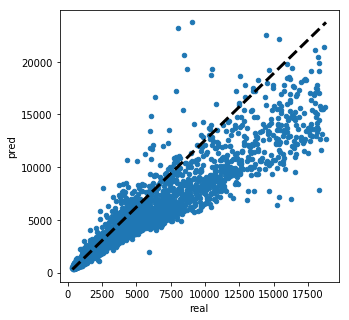

In [28]:
y_pred = np.exp(predict(theta_h, X_val))

df = pd.DataFrame({'real': y_val, 'pred': y_pred})
ax = df.sort_values('real').plot.scatter('real', 'pred', figsize=(5, 5))
_ = ax.plot([y_val.min(), y_val.max()], [y_pred.min(), y_pred.max()], 'k--', lw=3)



In [29]:
np.mean((np.log(y_pred) - np.log(y_val.values))**2)

0.04544866150423615

In [30]:
np.mean((y_pred - y_val.values)**2)

1836599.1822081285

MSE: 1836599.182
MAE: 713.255
R2: 0.886


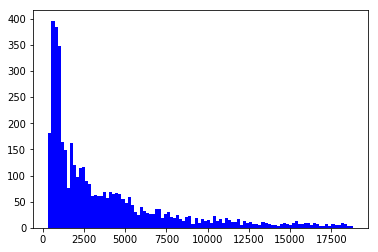

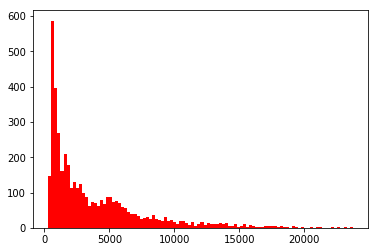

In [31]:
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()

Normal Equation --- RMSE error:  0.2140958539512833
MSE: 1862417.024
MAE: 713.933
R2: 0.884


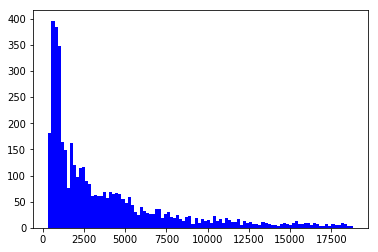

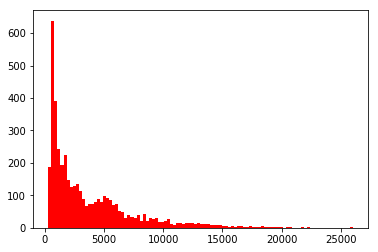

In [32]:
theta_h = normalEquation(X_train, y=np.log(y_train.values))
y_pred = np.exp(predict(theta_h, X_val))
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()

Normal Equation --- RMSE error:  1411.0794818433778
MSE: 1909779.812
MAE: 841.042
R2: 0.881


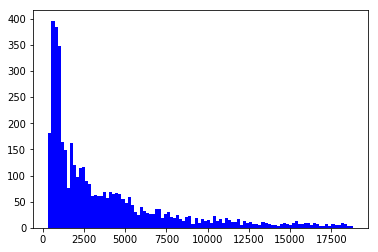

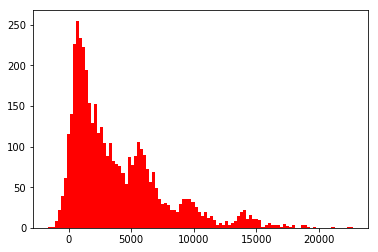

In [33]:
theta_h = normalEquation(X_train, y=y_train.values)
y_pred = predict(theta_h, X_val)
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()